In [28]:
import torch
from darts.models import NBEATSModel
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import yfinance as yf
import time
from datetime import datetime

In [44]:
start_date = datetime(2023, 10, 1).strftime('%Y-%m-%d')
end_date = datetime(2024, 10, 1).strftime('%Y-%m-%d')

#("ZEC-USD", "XMR-USD", "LTC-USD", "AXS-USD")
select_crypto = "AXS-USD"
select_model = 'N-BEATS'
df = yf.download(select_crypto, start=start_date, end=end_date)

df.columns = df.columns.get_level_values(0)
df = df.reset_index()
series = TimeSeries.from_dataframe(df, 'Date', 'Close')

[*********************100%***********************]  1 of 1 completed


In [45]:
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

# Split into train/test
train, val = series_scaled.split_before(0.8)

# Instantiate N-BEATS
model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    n_epochs=50,
    random_state=42
)

# Fit model
model.fit(train, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_criterion | MSELoss          | 0     
2 | val_criterion   | MSELoss          | 0     
3 | train_metrics   | MetricCollection | 0     
4 | val_metrics     | MetricCollection | 0     
5 | stacks          | ModuleList       | 6.2 M 
-----------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
49.945    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=50, random_state=42)

In [46]:
forecast = model.predict(n=200)
forecast = scaler.inverse_transform(forecast)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Date'>

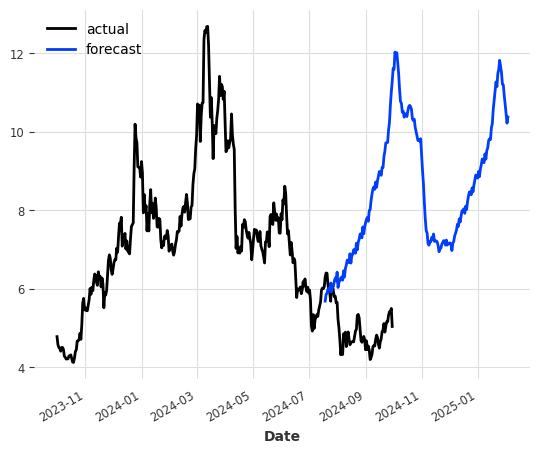

In [47]:
series.plot(label="actual")
forecast.plot(label="forecast")

In [48]:
model.save(f"{select_model}_{select_crypto}")

In [49]:
from darts.models import TransformerModel

In [67]:
start_date = datetime(2023, 10, 1).strftime('%Y-%m-%d')
end_date = datetime(2024, 10, 1).strftime('%Y-%m-%d')

#("ZEC-USD", "XMR-USD", "LTC-USD", "AXS-USD")
select_crypto = "ZEC-USD"
select_model = 'Transformer'
df = yf.download(select_crypto, start=start_date, end=end_date)

df.columns = df.columns.get_level_values(0)
df = df.reset_index()
series = TimeSeries.from_dataframe(df, 'Date', 'Close')

[*********************100%***********************]  1 of 1 completed


In [68]:
series = TimeSeries.from_dataframe(df, value_cols="Close")

# Normalize
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

In [69]:
train, val = series_scaled.split_before(0.8)

# Create Transformer model
model = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=7,
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.1,
    n_epochs=100,
    batch_size=16,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

# Train the model
model.fit(train, verbose=True)

C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_criterion     | MSELoss             | 0     
2 | val_criterion       | MSELoss             | 0     
3 | train_metrics       | MetricCollection    | 0     
4 | val_metrics         | MetricCollection    | 0     
5 | encoder             | Linear              | 128   
6 | positional_en

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=7, n_epochs=100, batch_size=16, optimizer_kwargs={'lr': 0.001}, random_state=42)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='time'>

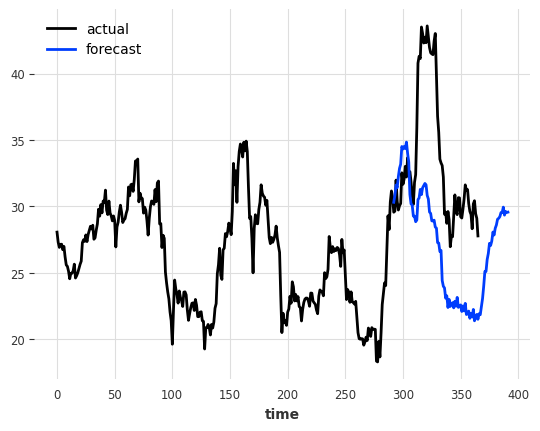

In [70]:
forecast = model.predict(n=100)
forecast = scaler.inverse_transform(forecast)

# Plotting
series.plot(label="actual")
forecast.plot(label="forecast")

In [71]:
model.save(f"{select_model}_{select_crypto}")